/tmp/SLURM_2644516/ipykernel_276520/191918581.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


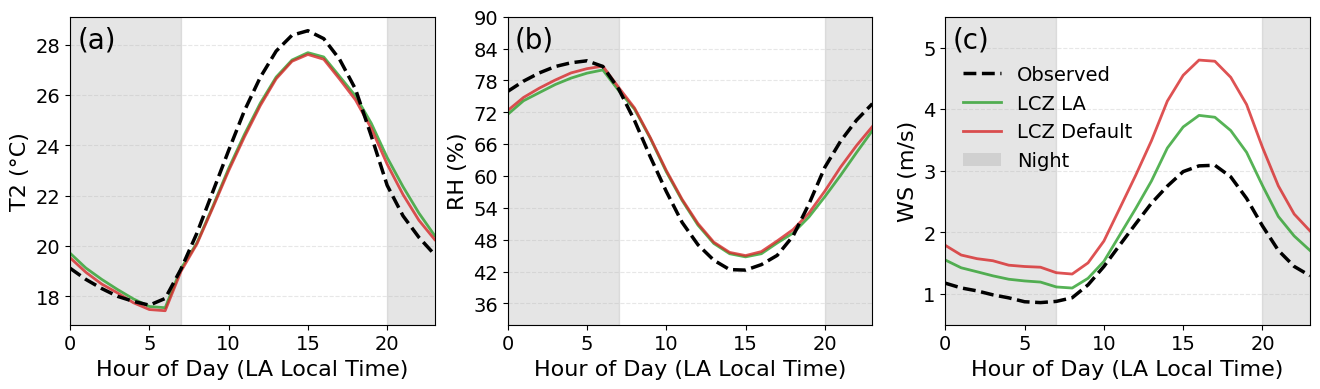

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

def prepare_diurnal_mean(csv_path, obs_col='T2_Obs', model_col='T2_model', time_col='LA Datetime'):

    df = pd.read_csv(csv_path).dropna(subset=[obs_col, model_col])

    df[time_col] = pd.to_datetime(df[time_col], utc=True)
    df[time_col] = df[time_col].dt.tz_convert('America/Los_Angeles')  
    
    df['Hour'] = df[time_col].dt.hour  
    hourly_mean = df.groupby('Hour').agg(
        avg_obs   = (obs_col, 'mean'),
        avg_model = (model_col, 'mean')
    ).reindex(range(24))
    return hourly_mean

if __name__ == '__main__':

    variables = [
        ('T2', 'T2 (°C)', {
            'Summer': [
             ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_T2_LCZ_LA_Summer.csv',    'LCZ LA'),
             ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_T2_LCZ_Default_Summer.csv','LCZ Default'),
            ],
        }),
        ('RH', 'RH (%)', {
            'Summer': [
             ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_RH_LCZ_LA_Summer.csv',    'LCZ LA'),
             ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_RH_LCZ_Default_Summer.csv','LCZ Default'),
            ],
        }),
        ('WS', 'WS (m/s)', {
            'Summer': [
           ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_WS_LCZ_LA_Summer.csv',    'LCZ LA'),
             ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_WS_LCZ_Default_Summer.csv','LCZ Default'),
            ],
        })
    ]

    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 16,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })

    hours = np.arange(24)
    night_mask = ( (hours >= 20) | (hours < 7) )
    cmap = {'LCZ LA':'C2','LCZ Default':'C3','NLCD Default':'C4'}
    linestyles = {'Summer':'-','Winter':'--'}
    letters = ['(a)','(b)','(c)']

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={'wspace':0.2})

    for i, (var, ylabel, seasons) in enumerate(variables):
        ax = axes[i]

        start = None
        for h in range(25):
            if h<24 and night_mask[h] and start is None:
                start = h
            if (h==24 or not (h<24 and night_mask[h])) and start is not None:
                ax.axvspan(start, h, color='gray', alpha=0.2, zorder=0)
                start = None

        for season in ['Summer']:
            files = seasons[season]
            ls = linestyles[season]

            obs = prepare_diurnal_mean(files[0][0])['avg_obs']
            ax.plot(hours, obs.values,
                    color='black', linestyle='--',
                    linewidth=2.5, label='Observed' if season=='Summer' and i==0 else None,
                    zorder=3)

            for path, label in files:
                series = prepare_diurnal_mean(path)['avg_model']
                ax.plot(hours, series.values,
                        color=cmap[label], linestyle=ls,
                        linewidth=2, alpha=0.8,
                        label=label if (season=='Summer' and i==2) else None,
                        zorder=2)

        ax.set_xlim(0,23)
        ax.set_ylabel(ylabel)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_xlabel('Hour of Day (LA Local Time)')
        
        ax.text(0.02, 0.90, letters[i], transform=ax.transAxes, fontsize=20)
        if i==1:
            ax.set_ylim(32,90)

        if i == 2:

            handles, labels = ax.get_legend_handles_labels()

            obs_proxy = Line2D([0], [0], color='black', linestyle='--', linewidth=2.5, label='Observed')

            night_patch = Patch(facecolor='gray', alpha=0.2, label='Night')

            handles = [obs_proxy] + handles + [night_patch]
            labels  = ['Observed'] + labels + ['Night']
            ax.legend(
                handles=handles,
                loc='upper center',               
                bbox_to_anchor=(0.28, 0.9),    
                frameon=False,
                fontsize=14
            )
            ax.set_ylim(0.5,5.5)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    plt.tight_layout()
    plt.show()
